# Phase 1: MDP Fundamentals & Dynamic Programming

**Goal**: Build intuition for the core RL framework before jumping to algorithms.

## What we'll cover:
1. Markov Decision Processes (MDPs)
2. Value Functions (V and Q)
3. Bellman Equations
4. Policy Iteration & Value Iteration
5. Hands-on: Solve FrozenLake with DP

In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from typing import Tuple, Dict

np.set_printoptions(precision=3)

---
## 1. Markov Decision Process (MDP)

An MDP is defined by the tuple $(S, A, P, R, \gamma)$:

- $S$ — Set of states
- $A$ — Set of actions
- $P(s' \mid s,a)$ — Transition probability
- $R(s,a,s')$ — Reward function
- $\gamma$ — Discount factor (0 to 1)

**Key insight**: The Markov property means the future depends only on the current state, not history.

### FrozenLake as an MDP

```
SFFF    S = Start
FHFH    F = Frozen (safe)
FFFH    H = Hole (fall, episode ends)
HFFG    G = Goal (reward = 1)
```

- **States**: 16 grid positions (0-15)
- **Actions**: 4 (Left, Down, Right, Up)
- **Transitions**: Slippery! 1/3 chance each of going intended direction or perpendicular
- **Rewards**: 1 at goal, 0 elsewhere

In [2]:
# Create FrozenLake environment
env = gym.make('FrozenLake-v1', is_slippery=True, render_mode='ansi')

print(f"State space: {env.observation_space.n} states")
print(f"Action space: {env.action_space.n} actions")
print(f"Actions: 0=Left, 1=Down, 2=Right, 3=Up")
print()
env.reset()
print(env.render())

State space: 16 states
Action space: 4 actions
Actions: 0=Left, 1=Down, 2=Right, 3=Up


SFFF
FHFH
FFFH
HFFG



In [3]:
# Inspect the transition dynamics P(s'|s,a)
# env.P[state][action] returns list of (probability, next_state, reward, done)

state = 0  # Start state
action = 2  # Right

print(f"From state {state}, taking action {action} (Right):")
for prob, next_state, reward, done in env.unwrapped.P[state][action]:
    print(f"  P={prob:.2f}: next_state={next_state}, reward={reward}, done={done}")
    
print("\nNotice: Slippery ice means you might go Down or Up instead!")

From state 0, taking action 2 (Right):
  P=0.33: next_state=4, reward=0, done=False
  P=0.33: next_state=1, reward=0, done=False
  P=0.33: next_state=0, reward=0, done=False

Notice: Slippery ice means you might go Down or Up instead!


---
## 2. Value Functions

### State Value Function $V^\pi(s)$
Expected return starting from state $s$, following policy $\pi$:

$$V^\pi(s) = \mathbb{E}_\pi\left[\sum_{t=0}^{\infty} \gamma^t R_t \mid S_0 = s\right]$$

### Action Value Function $Q^\pi(s, a)$
Expected return starting from state $s$, taking action $a$, then following $\pi$:

$$Q^\pi(s, a) = \mathbb{E}_\pi\left[\sum_{t=0}^{\infty} \gamma^t R_t \mid S_0 = s, A_0 = a\right]$$

**Why Q is useful**: We can pick the best action by comparing Q values!

---
## 3. Bellman Equations

The **key recursive relationship** that makes RL tractable.

### Bellman Expectation Equation (for a policy $\pi$)

$$V^\pi(s) = \sum_a \pi(a|s) \sum_{s'} P(s'|s,a) \left[ R(s,a,s') + \gamma V^\pi(s') \right]$$

**In words**: Value of a state = expected immediate reward + discounted value of next states.

### Bellman Optimality Equation (for optimal $V^*$)

$$V^*(s) = \max_a \sum_{s'} P(s'|s,a) \left[ R(s,a,s') + \gamma V^*(s') \right]$$

**Key insight**: Optimal policy picks the action that maximizes expected value.

---
## 4. Value Iteration

Iteratively apply Bellman optimality equation until convergence:

$$V_{k+1}(s) = \max_a \sum_{s'} P(s'|s,a) \left[ R + \gamma V_k(s') \right]$$

In [4]:
def value_iteration(env, gamma: float = 0.99, theta: float = 1e-8) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute optimal value function and policy using value iteration.
    
    Args:
        env: Gymnasium environment with P attribute (transition dynamics)
        gamma: Discount factor
        theta: Convergence threshold
    
    Returns:
        V: Optimal value function
        policy: Optimal deterministic policy
    """
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    
    V = np.zeros(n_states)
    
    iteration = 0
    while True:
        delta = 0
        for s in range(n_states):
            v = V[s]
            # Bellman optimality: take max over actions
            action_values = []
            for a in range(n_actions):
                q = sum(prob * (reward + gamma * V[next_s])
                        for prob, next_s, reward, _ in env.unwrapped.P[s][a])
                action_values.append(q)
            V[s] = max(action_values)
            delta = max(delta, abs(v - V[s]))
        
        iteration += 1
        if delta < theta:
            print(f"Converged after {iteration} iterations")
            break
    
    # Extract policy from value function
    policy = np.zeros(n_states, dtype=int)
    for s in range(n_states):
        action_values = []
        for a in range(n_actions):
            q = sum(prob * (reward + gamma * V[next_s])
                    for prob, next_s, reward, _ in env.unwrapped.P[s][a])
            action_values.append(q)
        policy[s] = np.argmax(action_values)
    
    return V, policy

In [5]:
# Run value iteration
V_opt, policy_opt = value_iteration(env)

# Visualize the optimal value function
print("Optimal Value Function (4x4 grid):")
print(V_opt.reshape(4, 4))
print()

# Visualize the optimal policy
action_symbols = ['←', '↓', '→', '↑']
policy_visual = np.array([action_symbols[a] for a in policy_opt]).reshape(4, 4)
print("Optimal Policy:")
for row in policy_visual:
    print(' '.join(row))

Converged after 324 iterations
Optimal Value Function (4x4 grid):
[[0.542 0.499 0.471 0.457]
 [0.558 0.    0.358 0.   ]
 [0.592 0.643 0.615 0.   ]
 [0.    0.742 0.863 0.   ]]

Optimal Policy:
← ↑ ↑ ↑
← ← ← ←
↑ ↓ ← ←
← → ↓ ←


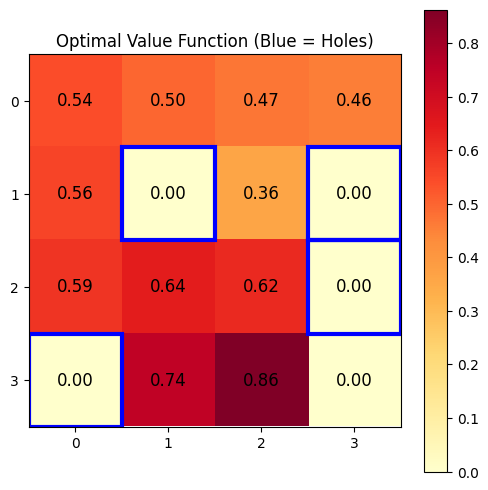

In [6]:
def visualize_value_function(V, title="Value Function"):
    """Plot value function as a heatmap."""
    fig, ax = plt.subplots(figsize=(6, 6))
    V_grid = V.reshape(4, 4)
    im = ax.imshow(V_grid, cmap='YlOrRd')
    
    # Add value annotations
    for i in range(4):
        for j in range(4):
            ax.text(j, i, f'{V_grid[i, j]:.2f}', ha='center', va='center', fontsize=12)
    
    # Mark special cells
    # Holes: 5, 7, 11, 12 -> (1,1), (1,3), (2,3), (3,0)
    holes = [(1, 1), (1, 3), (2, 3), (3, 0)]
    for (i, j) in holes:
        ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=False, edgecolor='blue', linewidth=3))
    
    ax.set_title(title)
    ax.set_xticks(range(4))
    ax.set_yticks(range(4))
    plt.colorbar(im)
    plt.show()

visualize_value_function(V_opt, "Optimal Value Function (Blue = Holes)")

---
## 5. Policy Iteration

Alternative approach with two steps:
1. **Policy Evaluation**: Compute $V^\pi$ for current policy
2. **Policy Improvement**: Greedily improve policy using $V^\pi$

Repeat until policy stops changing.

In [7]:
def policy_evaluation(env, policy: np.ndarray, gamma: float = 0.99, theta: float = 1e-8) -> np.ndarray:
    """
    Evaluate a policy by computing its value function.
    
    Args:
        env: Gymnasium environment
        policy: Policy to evaluate (array of actions per state)
        gamma: Discount factor
        theta: Convergence threshold
    
    Returns:
        V: Value function for the policy
    """
    n_states = env.observation_space.n
    V = np.zeros(n_states)
    
    while True:
        delta = 0
        for s in range(n_states):
            v = V[s]
            a = policy[s]
            V[s] = sum(prob * (reward + gamma * V[next_s])
                      for prob, next_s, reward, _ in env.unwrapped.P[s][a])
            delta = max(delta, abs(v - V[s]))
        
        if delta < theta:
            break
    
    return V


def policy_iteration(env, gamma: float = 0.99) -> Tuple[np.ndarray, np.ndarray]:
    """
    Find optimal policy using policy iteration.
    
    Args:
        env: Gymnasium environment
        gamma: Discount factor
    
    Returns:
        V: Optimal value function
        policy: Optimal policy
    """
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    
    # Start with random policy
    policy = np.zeros(n_states, dtype=int)
    
    iteration = 0
    while True:
        # Policy Evaluation
        V = policy_evaluation(env, policy, gamma)
        
        # Policy Improvement
        policy_stable = True
        for s in range(n_states):
            old_action = policy[s]
            
            # Find best action
            action_values = []
            for a in range(n_actions):
                q = sum(prob * (reward + gamma * V[next_s])
                        for prob, next_s, reward, _ in env.unwrapped.P[s][a])
                action_values.append(q)
            policy[s] = np.argmax(action_values)
            
            if old_action != policy[s]:
                policy_stable = False
        
        iteration += 1
        if policy_stable:
            print(f"Policy converged after {iteration} iterations")
            break
    
    return V, policy

In [8]:
# Run policy iteration
V_pi, policy_pi = policy_iteration(env)

print("\nPolicies match:", np.array_equal(policy_opt, policy_pi))
print("Value functions match:", np.allclose(V_opt, V_pi))

Policy converged after 7 iterations

Policies match: True
Value functions match: True


---
## 6. Test the Optimal Policy

In [9]:
def evaluate_policy(env, policy: np.ndarray, n_episodes: int = 1000) -> float:
    """
    Evaluate a policy by running episodes and computing success rate.
    
    Args:
        env: Gymnasium environment
        policy: Policy to evaluate
        n_episodes: Number of episodes to run
    
    Returns:
        Success rate (fraction of episodes reaching goal)
    """
    successes = 0
    for _ in range(n_episodes):
        state, _ = env.reset()
        done = False
        while not done:
            action = policy[state]
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            if reward == 1:
                successes += 1
    
    return successes / n_episodes

# Compare random vs optimal policy
random_policy = np.random.randint(0, 4, size=16)

random_success = evaluate_policy(env, random_policy)
optimal_success = evaluate_policy(env, policy_opt)

print(f"Random policy success rate:  {random_success:.1%}")
print(f"Optimal policy success rate: {optimal_success:.1%}")

Random policy success rate:  0.9%
Optimal policy success rate: 76.4%


---
## Key Takeaways

1. **MDPs** formalize sequential decision making with states, actions, transitions, rewards

2. **Value functions** tell us how good states/actions are under a policy

3. **Bellman equations** decompose value into immediate reward + future value (recursive structure!)

4. **Value Iteration** directly finds optimal value, then extracts policy

5. **Policy Iteration** alternates between evaluation and improvement

### Limitations of Dynamic Programming
- Requires **full knowledge** of P(s'|s,a) - the transition dynamics
- Scales poorly: O(|S|²|A|) per iteration
- Not practical for large or continuous state spaces

**Next**: Q-learning and SARSA - learn without knowing the dynamics!

---
## Exercises

1. **Non-slippery FrozenLake**: Set `is_slippery=False`. How do the optimal values change?

2. **Discount factor**: Try γ = 0.5, 0.9, 0.999. What happens to the value function?

3. **8x8 FrozenLake**: Use `FrozenLake-v1` with `map_name="8x8"`. Does it still converge?

4. **Implement Q-function version**: Modify value_iteration to compute Q(s,a) instead of V(s)